<a href="https://colab.research.google.com/github/oreilly-japan/ml-at-work/blob/master/chap10/LR-forbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-947-2.gif)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

In [1]:
import random

def generate_sample_data(num, seed=1):
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []

    random_instance = random.Random(seed)

    feature_num = 8
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]

    for i in range(num):
        is_treat = random_instance.choice((True, False))
        feature_vector = [random_instance.random() for n in range(feature_num)]
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])

        if is_treat:
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])

        is_cv = cv_rate > random_instance.random()

        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)

    return is_cv_list, is_treat_list, feature_vector_list


In [2]:
generate_sample_data(2)

([False, False],
 [True, False],
 [[0.5692038748222122,
   0.8022650611681835,
   0.06310682188770933,
   0.11791870367106105,
   0.7609624449125756,
   0.47224524357611664,
   0.37961522332372777,
   0.20995480637147712],
  [0.43276706790505337,
   0.762280082457942,
   0.0021060533511106927,
   0.4453871940548014,
   0.7215400323407826,
   0.22876222127045265,
   0.9452706955539223,
   0.9014274576114836]])

In [3]:

from sklearn.linear_model import LogisticRegression

# train 데이터 생성
sample_num = 100000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

# 학습기 생성
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

# 데이터를 treatment와 control로 분리
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])

# 학습기 구현
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))


treatment_cvr 0.0309636212163288
control_cvr 0.029544629532529343


In [5]:
treat_model.coef_

array([[ 0.31055692,  0.51399856,  0.81982066,  0.25254976, -0.93963072,
         0.0763356 , -0.06571689, -0.00510506]])

In [6]:
control_model.coef_

array([[ 0.41333519,  0.52454461,  0.89237087, -0.65533809, -0.01929802,
        -0.00734836,  0.03272097,  0.07835321]])

In [7]:
# seed를 바꿔 테스트 데이터 생성
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

# 각 학습기별로 CVR 예측
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# 점수 산출, 점수 = (실험군의 예측 CVR) / (통제군의 예측 CVR)
# predict_proba는 클래스에 속할 확률 목록을 반환하므로 첫 번째 인자를 참조
# model.clases_를 참조하면 어떤 클래스가 몇 번째에 있는지 알 수 있음
score_list = treat_score[:,1] / control_score[:,1]

In [8]:
%config InlineBackend.figure_formats = {'png', 'retina'}

Text(0, 0.5, 'conversion rate')

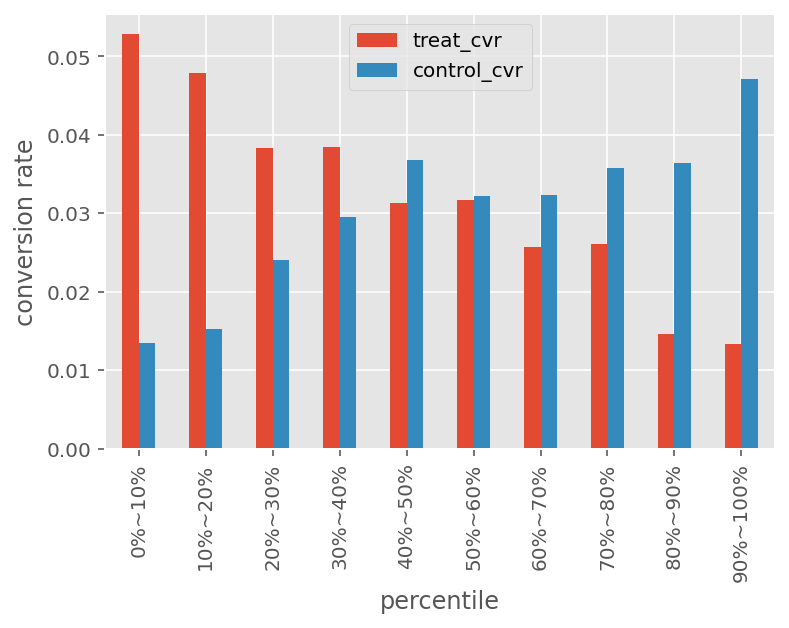

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
plt.style.use('ggplot')

%matplotlib inline 

# 점수가 높은 순서대로 정렬
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)

    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)

    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("conversion rate")

Text(0, 0.5, 'conversion lift')

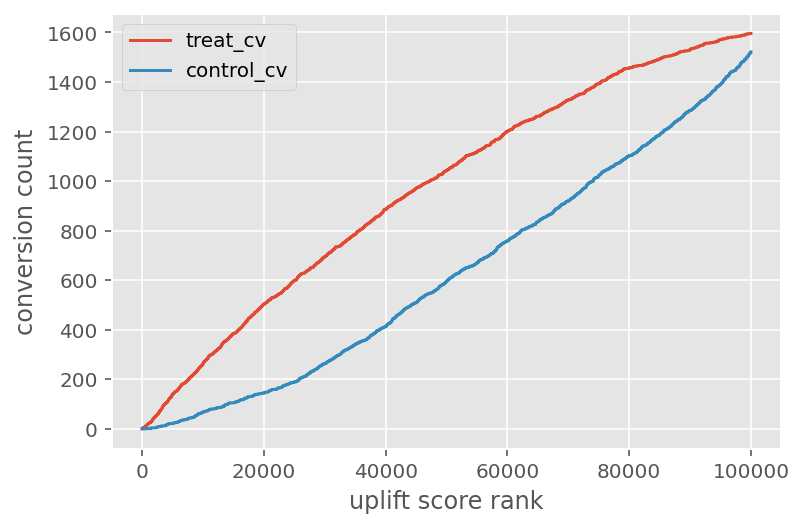

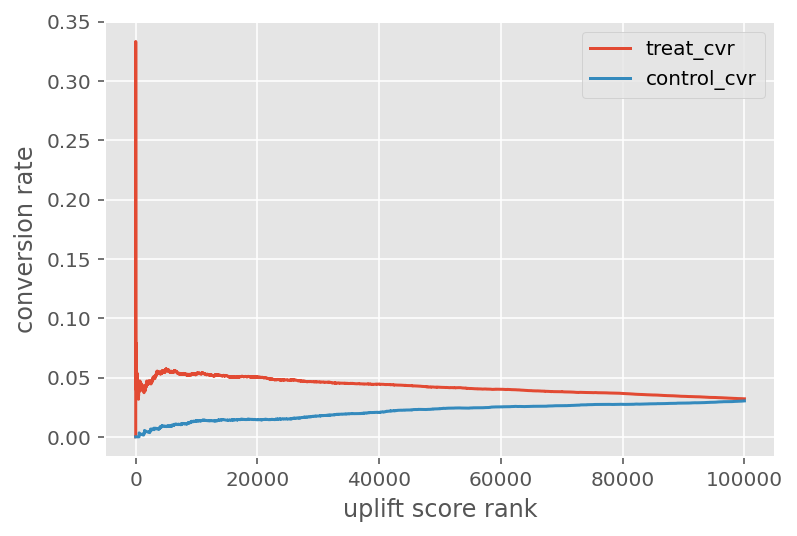

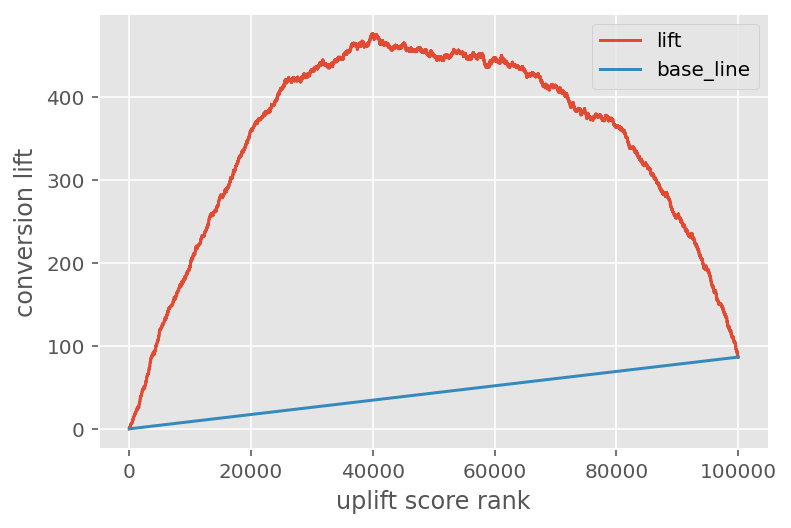

In [10]:
# 점수 순으로 집계
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

    # 컨버전율의 차와 실험군의 사람 수를 곱해서 lift를 산출
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

# 통계 데이터를 DataFrame으로 변환
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

# 베이스라인 추가
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

# 시각화
df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion count")

df.plot(y=["treat_cvr", "control_cvr"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")


df.plot(y=["lift", "base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion lift")


Text(0, 0.5, 'conversion lift')

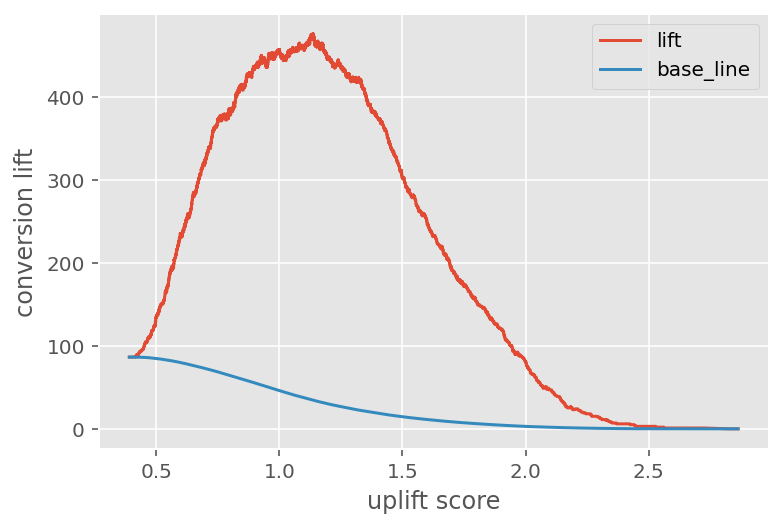

In [11]:
# df.plot(x="score", y=["treat_cv", "control_cv"], title="conversion count")
# df.plot(x="score", y=["treat_cvr", "control_cvr"], title="conversion rate")
df.plot(x="score", y=["lift", "base_line"])
plt.xlabel("uplift score")
plt.ylabel("conversion lift")



In [12]:
auuc = (df["lift"] - df["base_line"]).sum() / len(df["lift"])
print("AUUC:", auuc)

AUUC: 302.1527035956181
